# Analyzing Proteomes in Patients with Breast Cancer

_Authors: Elin Chee & Avena Cheng_

_Instructor: Jonathon Fischer_

_Course: LS88 - Data Science in Genetics and Genomics_

The goal of our project is to analyze proteomes in patients with breast cancer. In particular, we would like to see if there is some association with specific proteomes and the stages of breast cancer in patients.

We analyzed a dataset containing 77 patients, each patient with different stages of cancer. We began by exploring the most common stage type, the ages of the patients, and the genes associated with proteomes. Our dataset contains over 12,000 proteomes, but only 50 types of genes. Thus,though we could not feasibly explore the distributions of each proteome, we still wanted to see how genes were affiliated with the stage.

We then performed PCA on our data matrix and plotted the projections of the PC1 and PC2 to see if the projections separated by Stages in any visually distinct way. We then performed a dimension reduction technique, t-SNE, to the principal components to see if it improved the visualization/allowed for greater distinction between the stages of cancer.

Even though all of our data was already labeled, we also performed K-means on the data as a fun side experiment to see how it differed with the PCA results from before. 

Finally, we created different classifiers to try to predict the stage from just the proteomes using random forest and logistic regression. We tried various feature engineering ideas, such as keeping only top features, normalizing, and trying to predict with just the two most common stages.

# Data Loading and Processing

## Before we begin:

First make sure to upload the three csv files on this link:
https://www.kaggle.com/piotrgrabo/breastcancerproteomes


In [0]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sns
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE

In [0]:
proteomes = pd.read_csv("/content/77_cancer_proteomes_CPTAC_itraq.csv")
pam50 = pd.read_csv("/content/PAM50_proteins.csv")
breast_cancer = pd.read_csv("/content/clinical_data_breast_cancer.csv")

In [45]:
### @source: kajot - Breast Cancer Proteomes (Kaggle, cited below)
### Set path to the data set
dataset_path = "77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "clinical_data_breast_cancer.csv"
pam50_proteins = "PAM50_proteins.csv"
 
## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)
 
## Drop unused information columns
##data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)
 
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
data = data.transpose()
 
## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]
 
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data.merge(clinical,left_index=True,right_index=True)
 
## Change name to make it look nicer in the code!
processed = merged
processed.head(3)

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,NP_076965,NP_001367,NP_036222,NP_001138241,NP_001714,NP_002464,NP_001073936,NP_061198,NP_001074248,NP_001074419,NP_056009,NP_036355,NP_001155291,NP_002462,NP_000248,NP_036467,NP_004989,NP_001243024,NP_149043,NP_067047,NP_002461,NP_060003,NP_003793,NP_060004,NP_005954,NP_002463,NP_689914,NP_001242941,NP_060227,NP_055796,...,NP_001164045,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.65215,-0.984373,-0.547225,0.654015,-0.672124,-1.43622,-0.150485,-0.308446,0.136049,-1.5905,-0.716207,-0.705186,-1.22315,-1.9101,-1.90275,-1.05417,-1.05417,0.598913,0.867079,-0.701512,1.12423,0.161764,-0.337834,-0.664777,-0.374569,-0.374569,-0.374569,-0.110076,-0.0696675,-0.712533,NaN,-0.172526,...,NaN,NaN,NaN,1.15361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.0975117,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.51247,-1.40603,0.0775532,0.493355,-0.594383,-0.00228077,0.932442,-1.59563,-1.2131,-0.295005,-0.295005,0.436806,-0.361534,-0.408103,1.01893,1.16196,1.21851,2.2364,0.689613,1.39149,-3.16237,1.16196,1.305,1.01893,1.16196,1.16196,1.01893,-0.677543,0.686287,-4.07049,-1.20312,...,-5.15822,0.919136,-1.64886,0.832649,NaN,-8.32497,-4.67922,NaN,-1.10665,NaN,-6.94118,FEMALE,45,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIB,Stage IIA,followup,LIVING,1027,NaN,0,1027,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.91267,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.07115,-2.27894,-2.23684,-0.598849,-1.47143,-1.7508,-2.05697,-1.21501,1.2726,-1.41402,-1.21501,-1.30686,-0.537615,0.974087,0.931989,-1.84265,-1.52501,0.461257,-0.61033,-1.98426,2.38246,0.671747,-1.28773,-1.52501,-1.45229,-1.48673,-1.48673,-1.45229,2.40159,-1.99191,NaN,-0.120462,...,-0.970077,-0.801685,NaN,NaN,3.80231,-6.37393,-1.12316,NaN,NaN,NaN,NaN,FEMALE,64,Negative,Negative,Positive,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,LIVING,2426,NaN,0,2426,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1


# EDAs

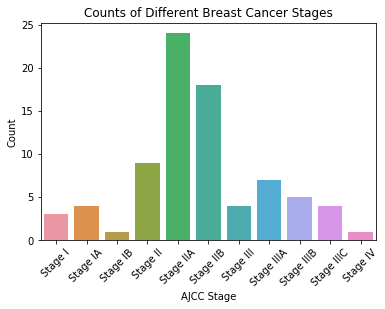

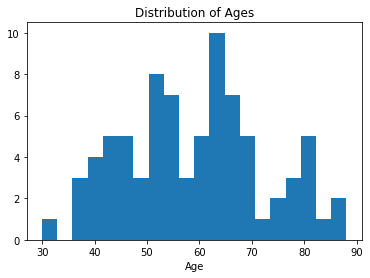

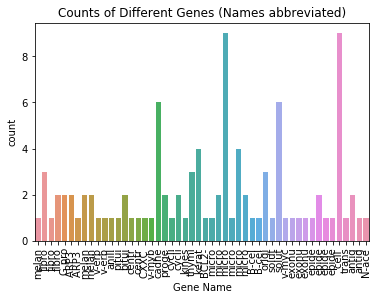

In [46]:
stages = processed['AJCC Stage']
grouped_by_stage = processed.groupby('AJCC Stage').count()
stage_plot = sns.barplot(grouped_by_stage.index, grouped_by_stage.iloc[:, 0])
stage_plot.set_xticklabels(rotation=45, labels = grouped_by_stage.index)
stage_plot.set_title('Counts of Different Breast Cancer Stages')
plt.ylabel('Count')
plt.show()

#stages = processed['AJCC Stage']
#stage_plot = sns.countplot(stages)
#stage_plot.set_xticklabels(rotation=45, labels = stages.values)
#stage_plot.set_title('Counts of Different Breast Cancer Stages')
#plt.show()

plt.hist(processed['Age at Initial Pathologic Diagnosis'],bins=20)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.show()
genes = pam50['Gene Name']
gene_plot = sns.countplot(genes)
gene_names = [name[:5] for name in genes.values]
gene_plot.set_xticklabels(rotation=90, labels = gene_names)
gene_plot.set_title('Counts of Different Genes (Names abbreviated)')
plt.show()

## Visualization via PCA

In [47]:
new_data = processed.iloc[:, :-29]
new_data = new_data.fillna(new_data.mean())
normed_data = (new_data - np.mean(new_data))/np.std(new_data)
normed_data = normed_data.astype('float64')
normed_data.head()


,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,NP_076965,NP_001367,NP_036222,NP_001138241,NP_001714,NP_002464,NP_001073936,NP_061198,NP_001074248,NP_001074419,NP_056009,NP_036355,NP_001155291,NP_002462,NP_000248,NP_036467,NP_004989,NP_001243024,NP_149043,NP_067047,NP_002461,NP_060003,NP_003793,NP_060004,NP_005954,NP_002463,NP_689914,NP_001242941,NP_060227,NP_055796,...,NP_061841,NP_001014979,NP_848561,NP_000331,NP_690591,XP_003960234,NP_000237,NP_057387,NP_004187,NP_065087,NP_004953,NP_001034806,NP_065119,NP_110392,NP_620138,NP_062558,NP_001005163,NP_665813,NP_005279,NP_998761,YP_003024032,NP_001165887,NP_001010893,NP_872303,NP_000871,NP_690872,NP_683762,NP_060064,NP_699174,NP_001164045,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-A2-A0CM,0.368358,0.371592,0.375784,0.368078,0.363905,0.376081,0.376028,0.375916,-1.145399,-0.939449,-0.505275,0.848353,-0.178706,-1.090303,-0.071109,-0.294353,0.531333,-1.120976,-0.801104,-0.795137,-1.407935,-1.360541,-1.357627,-0.607929,-0.702737,0.424719,0.652892,-0.572461,0.638568,0.260318,-0.296717,-0.468364,-0.349257,-0.373719,-0.303181,-0.118088,0.031997,-0.579807,6.378680e-17,0.287802,...,1.506737e+00,-2.740300e-16,-1.749245e-01,-5.434087e-01,0.000000,3.425549e-01,-1.427425e-15,1.017224,5.417509e-16,1.341857e+00,-4.670450e-02,-4.094964e-16,-2.073946e-17,4.991971e-16,2.514340e-17,-1.451159e+00,-2.177927e-01,-0.978110,1.019981e+00,1.422186e+00,8.763682e-01,-2.148006e-01,-3.007964,2.586001e+00,1.449256e-16,-2.748021e-01,-0.043139,-2.550451e-16,4.936824e-01,8.046422e-16,8.166276e-17,-2.118622e-16,8.943352e-01,-3.254048e-17,0.000000,2.094242e-16,8.643338e-17,4.373183e-16,1.477620e-16,4.359203e-16
TCGA-A2-A0D2,-0.215506,-0.224805,-0.221047,-0.228601,-0.224678,-0.224303,-0.223710,-0.223774,-0.280952,-1.302269,-1.097561,0.156477,0.943757,-0.426633,0.012710,0.897659,-0.594252,-0.820762,-0.513055,-0.515418,0.013657,-0.209433,-0.245244,0.506271,0.656425,0.887204,1.832524,0.743257,0.833849,-1.364929,0.789184,0.856152,0.684075,0.727119,0.721593,0.644943,-0.554522,0.745384,-1.813522e+00,-0.281274,...,-8.383134e-16,-2.740300e-16,3.938086e-01,1.696540e-17,0.000000,2.099389e+00,-1.427425e-15,-0.519144,5.417509e-16,-9.539148e-01,5.348871e-01,-4.873976e-01,-7.118570e-01,1.330002e+00,2.514340e-17,2.297372e-16,-8.772783e-02,1.979113,-1.743590e+00,-1.385479e-16,-7.198388e-16,7.980281e-01,-0.808721,-1.579467e+00,1.892206e-01,1.185841e+00,-0.189747,-2.550451e-16,-2.321853e-01,-6.073948e-01,7.050756e-01,-7.696804e-01,6.104191e-01,-3.254048e-17,-1.147506,-2.476039e-01,8.643338e-17,-5.130410e-01,1.477620e-16,-1.849179e+00
TCGA-A2-A0EQ,-1.249753,-1.267682,-1.267428,-1.270337,-1.266861,-1.267655,-1.265941,-1.265923,-1.349839,-1.828856,-1.670547,-0.655346,-0.948506,-1.338312,-1.149342,-1.165211,1.270085,-0.980589,-1.142224,-1.205445,-0.820839,0.783384,0.752112,-1.031705,-0.991501,0.321969,-0.619858,-1.785672,1.557926,0.509660,-0.984468,-1.046798,-1.148428,-1.170521,-1.044928,-1.025217,2.416437,-1.791842,6.378680e-17,0.316552,...,-8.383134e-16,1.165327e+00,-2.206334e-17,-1.704977e+00,0.000000,-7.972643e-16,-1.427425e-15,-0.076015,5.417509e-16,-6.719554e-01,-6.948993e-16,-4.094964e-16,1.432818e+00,4.991971e-16,2.514340e-17,7.258284e-01,7.332961e-16,-0.961258,4.184292e-01,1.449483e+00,-7.198388e-16,-8.142389e-17,1.604210,2.595225e-16,1.449256e-16,-3.742433e-01,-0.115149,-2.550451e-16,1.091660e-17,6.573508e-01,7.219850e-02,-2.118622e-16,7.365536e-17,2.041369e+00,-0.545352,5.908815e-01,8.643338e-17,4.373183e-16,1.477620e-16,4.359203e-16
TCGA-A2-A0EV,0.134759,0.147452,0.147900,0.136831,0.147331,0.148124,0.148316,0.148223,-0.213822,0.981243,1.221739,-0.233252,-0.516564,-0.044713,0.027853,0.003951,-0.384012,-0.212798,2.532368,2.487017,0.687084,-0.301371,-0.294297,-1.476197,-1.372342,0.589643,0.665296,-0.142741,1.134440,0.100093,-2.313540,-1.816502,-1.747966,-2.018037,-1.833884,-1.847985,-0.495955,-0.138933,4.3783

In [0]:
# Run the following cell
x = StandardScaler().fit_transform(normed_data)
pca = PCA(n_components = 80)
principalComponents = pca.fit_transform(x)


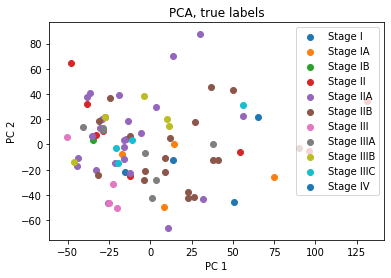

In [49]:
# Plot the projections and see if they separate by stages. 
legend_label = []
for i in np.unique(processed['AJCC Stage']):
  plt.scatter(principalComponents[processed['AJCC Stage'] == i,0], principalComponents[processed['AJCC Stage'] == i,1])
  legend_label.append(i)

plt.legend(legend_label)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, true labels')
plt.show()

## Visualization using t-SNE 

In [0]:
# t-SNE is a non-linear dimenstion reduction method which we apply after the PCA which we performed previously.
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)


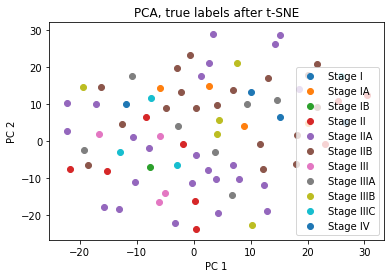

In [51]:
# Now plot the t-SNE embeddings and see what's changed.
legend_label = []
for i in np.unique(processed['AJCC Stage']):
  plt.scatter(X_embedded[processed['AJCC Stage'] == i,0], X_embedded[processed['AJCC Stage'] == i,1])
  legend_label.append(i)

plt.legend(legend_label)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, true labels after t-SNE')
plt.show()

# Cluster Exploration: K-Means

In [0]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X_embedded)
predictions = kmeans.predict(X_embedded)

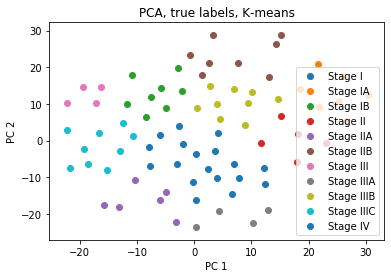

In [53]:
legend_label_1 = []
for i in np.arange(11):
  plt.scatter(X_embedded[predictions == i,0], X_embedded[predictions == i,1])
  legend_label_1.append(np.unique(processed['AJCC Stage'])[i])

plt.legend(legend_label_1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, true labels, K-means')
plt.show()

# Splitting Into Train/Test Sets

**NOTE: there are NaN values so I inputted them with the mean, but it will take about 3 minutes to run**

In [0]:
# Split into train and test sets
features = processed[[col for col in data.columns if col not in clinical.columns]]
mean_val = features.mean()
features = features.fillna(mean_val)
labels = stages
#labels = new_processed.index


# Random Forest Classifier
## Creation and Analysis

#### Using Original Data

In [55]:
org_accs = []
for i in range(30):
    # Fit model
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
    clf=RandomForestClassifier(n_estimators = 150)
    clf.fit(X_train, y_train)
    # Compute train and test errors
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    org_accs.append(np.mean(y_test_pred == y_test))
np.mean(org_accs)

0.33125

In [56]:
# Feature importances. Let's look at the top genes
feature_imp = pd.Series(clf.feature_importances_,index = X_train.T.index)
feature_imp.sort_values(ascending=False)[0:10]

NP_001484    0.002882
NP_001433    0.002823
NP_659409    0.002692
NP_705690    0.002339
NP_055157    0.002326
NP_001928    0.002269
NP_002292    0.002237
NP_006253    0.002225
NP_005549    0.002168
NP_002112    0.002139
dtype: float64

### **Now we will try to improve our model**

Keeping only important features (top 100)

In [57]:
few_features = features[feature_imp.sort_values(ascending=False)[0:100].index]
few_accs = []
for i in range(30):
    # Fit model
    X_train, X_test, y_train, y_test = train_test_split(few_features, labels, test_size=0.2)
    clf=RandomForestClassifier(n_estimators = 150)
    clf.fit(X_train, y_train)
    # Compute train and test errors
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    few_accs.append(np.mean(y_test_pred == y_test))
np.mean(few_accs)

0.4375

In [58]:
X_train, X_test, y_train, y_test = train_test_split(few_features, labels, test_size=0.2)
clf=RandomForestClassifier(n_estimators = 150)
clf.fit(X_train, y_train)
# Compute train and test errors
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
results = pd.DataFrame({'Predicted':y_test_pred,'Actual':y_test,'Mislabelled':y_test_pred!=y_test})
results.head()

,Predicted,Actual,Mislabelled
TCGA-AO-A0JJ,Stage IIB,Stage IIB,False
TCGA-AO-A12B,Stage IIA,Stage IIA,False
TCGA-AN-A04A,Stage IIA,Stage IIIA,True
TCGA-A2-A0SW,Stage IIB,Stage IV,True
TCGA-C8-A138,Stage IIA,Stage III,True


### Experiment 1: Testing on a few stages rather than all.

Let's try just using Stage IIA and Stage IIB.

In [59]:
labels.value_counts()

Stage IIA     24
Stage IIB     18
Stage II       9
Stage IIIA     7
Stage IIIB     5
Stage III      4
Stage IIIC     4
Stage IA       4
Stage I        3
Stage IV       1
Stage IB       1
Name: AJCC Stage, dtype: int64

In [0]:
experiment_data = pd.concat([features,labels],axis=1)
experiment_data = experiment_data[(experiment_data['AJCC Stage']=='Stage IIA') | (experiment_data['AJCC Stage']=='Stage IIB')]
experiment_features = experiment_data[[col for col in data.columns if col not in clinical.columns]]
experiment_labels = experiment_data['AJCC Stage']

In [61]:
exp1 = experiment_features[feature_imp.sort_values(ascending=False)[0:100].index]
exp1_accs = []
persons_incorrectly_classified = []
for i in range(100):
    # Fit model
    X_train, X_test, y_train, y_test = train_test_split(exp1, experiment_labels, test_size=0.3)
    clf=RandomForestClassifier(n_estimators = 150)
    clf.fit(X_train, y_train)
    # Compute train and test errors
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    exp1_accs.append(np.mean(y_test_pred == y_test))
    results1 = pd.DataFrame({'Predicted':y_test_pred,'Actual':y_test,'correct_prediction':y_test_pred==y_test})
    persons_incorrectly_classified.append(list(results1[results1.correct_prediction==False].index))
np.mean(exp1_accs)

0.7846153846153847

In [0]:
X_train, X_test, y_train, y_test = train_test_split(exp1, experiment_labels, test_size=0.3)
clf = RandomForestClassifier(n_estimators = 150)
clf.fit(X_train, y_train)
# Compute train and test errors
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
results1 = pd.DataFrame({'Predicted':y_test_pred,'Actual':y_test,'correct_prediction':y_test_pred==y_test})

In [0]:
import itertools
people_incorrectly_classified = pd.DataFrame({'p':list(itertools.chain.from_iterable(persons_incorrectly_classified))})
people_incorrectly_classified = pd.DataFrame({'num':people_incorrectly_classified.p.value_counts()})
people_incorrectly_classified = people_incorrectly_classified[people_incorrectly_classified.num > 20]

Text(0.5, 1.0, 'Number of missing entries in Incorrectly Classified People')

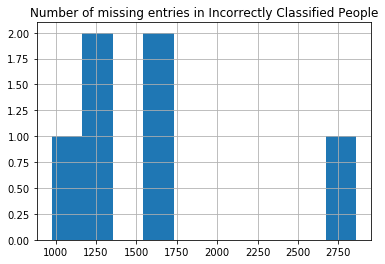

In [64]:
processed[processed.index.isin(people_incorrectly_classified.index)].isnull().sum(axis=1).hist();
plt.title('Number of missing entries in Incorrectly Classified People')

Text(0.5, 1.0, 'Number of missing entries in Correctly Classified People')

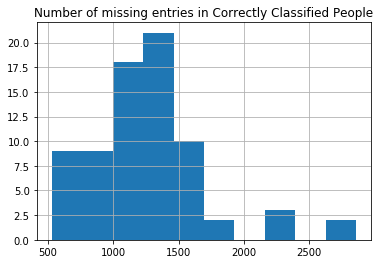

In [65]:
everyone_else = pd.DataFrame({'num':processed[~processed.index.isin(people_incorrectly_classified.index)].isnull().sum(axis=1)})
everyone_else.hist();
plt.title('Number of missing entries in Correctly Classified People')

In [66]:
# Feature importances. Let's look at the top genes
feature_imp1 = pd.Series(clf.feature_importances_,index = X_train.T.index)
feature_imp1.sort_values(ascending=False)[0:3]

NP_079291    0.048794
NP_006626    0.046848
NP_940876    0.036425
dtype: float64

**Exploring Correlations**

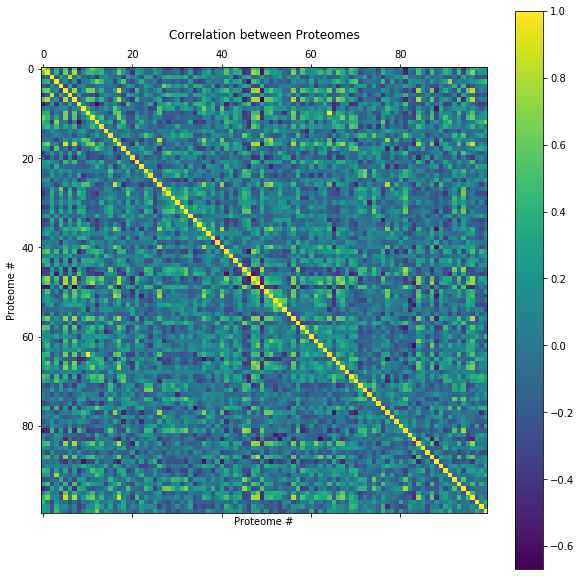

In [67]:
import scipy

corr = exp1.corr()
f = plt.figure(figsize=(10,10))
plt.matshow(corr, fignum=f.number)
cb = plt.colorbar()
plt.xlabel('Proteome #')
plt.ylabel('Proteome #')
plt.title('Correlation between Proteomes');

### Experiment 2: Normalized Features

In [68]:
features_norm = features / features.sum() * features.sum().median()

norm_accs = []
for i in range(10):# Fit model
    X_train, X_test, y_train, y_test = train_test_split(features_norm, labels, test_size=0.2)
    clf=RandomForestClassifier(n_estimators = 150)
    clf.fit(X_train, y_train)
    # Compute train and test errors
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    norm_accs.append(np.mean(y_test_pred == y_test))
np.mean(norm_accs)

0.375

### Experiment 3: Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [70]:
exp2 = experiment_features[feature_imp.sort_values(ascending=False)[0:100].index]
exp2_accs = []
for i in range(100):
    # Fit model
    X_train, X_test, y_train, y_test = train_test_split(exp2, experiment_labels, test_size=0.3)
    clf=LogisticRegression(solver = 'lbfgs')
    clf.fit(X_train, y_train)
    # Compute train and test errors
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    exp2_accs.append(np.mean(y_test_pred == y_test))
np.mean(exp2_accs)

0.7830769230769231

# Conclusion
After we performed PCA on our dataset, the visualization that mapped the PC1 values against the PC2 values did not show a clear distinction between the cancer stages. Additionally, after performing t-SNE afterwards, the visualization of the first two Principal Components still did not show very clear visual distinctions between the different stages. It seems that after t-SNE, the data points are more evenly spread out than without, but it is difficult to make out different cancer stages in both visualizations. 

For fun, we performed a k-means clustering algorithm for the 11 cancer stages. We can see that the k-means clustering does not remotely resemble the previous visualizations and is definitely not perfect.

From these visualizations, it seems as though the proteomes in our dataset might not be a good indicator of breast cancer stages. Perhaps more proteomes would be needed to draw a clearer correlation between certain proteomes and stages of breast cancer, or more patient samples.

We found that it is much easier to classify fewer stages than it is to classify multiple. When we tried classifying all 11, we could only reach an accuracy around 40%, but when we switched to binary classification, we were able to get a 77% accuracy. Random Forest and Logistic Regression had around the same performance, but random forest took much longer, so for binary classification it would probably be best to stick with Logistic. We also found that normalizing the data actually decreased the accuracy (perhaps indicating that values have already been normalized). After looking into features that were used in our binary classifier, we found there wasn't an explicitly clear correlation between different proteomes. However, we did notice that the people who were incorrectly classified had more entries that were NaN than correctly classified, so this could indicate that imputing missing values with the mean is not enough.

# Credits:

Dataset + Reshaping functions: https://www.kaggle.com/piotrgrabo/breastcancerproteomes

The original study: http://www.nature.com/nature/journal/v534/n7605/full/nature18003.html